!["Intro"](assets/intro_banner.png)


We now continue our journey diving deeper into the dynamics of single and multiple atom systems.

### Learning Objectives

#### By the end of the session, you will be able to:
- Describe the Rydberg bloqade phenomenon
- Compute the dynamics of multi-qubit Rydberg systems describing the effects of the blockade on Rabi oscillations
- Analyze Rydberg phases on square lattices

## 1. Intro to Rydberg dynamics


Now that we have learned all the basic control parameters for neutral-atom analog quantum computers, we can start looking at running programs and studying interesting dynamics for problem solving. This is the theme of this chapter.

### 1a. Dynamics for a single atom

In this section we will look more formally at the effect of the Rabi drive on a single atom, and then multiple atoms. 

We saw in Chapter I that we control this Rabi drive with the Rabi waveform $\Omega (t)$. If $\phi = 0$, and $\Delta = 0$, and we only have one atom, then the Hamiltonian of the problem simplifies to just:

$$
H = \frac{\Omega(t)}{2} \left(|g\rangle\langle r| +|r\rangle\langle g|\right) \equiv \frac{\Omega(t)}{2} \sigma_x
$$

where we represent the state flipping operator as $\sigma_x \equiv \left(|g\rangle\langle r| +|r\rangle\langle g|\right)$, i.e., using the corresponding real-valued Pauli matrix.

### 1b. Rabi oscillations

**Rabi oscillations** is a canonical phenomenon in quantum dynamics. Given a single two-level system - aka, a qubit - started in the $|0\rangle$ of the computational '$z$-basis', and a driving field around an axis not parallel with this $z$, we observe oscillations in the qubit state. 

Here is a diagram with the corresponding mathematical solutions:

<img src="assets/Rabi_diagram.png" width="500" height="auto" />

The simplest scenario occurs in the presence of a constant field in a direction perpendicular to $z$, say $x$ as in the figure above. As time $t$ advances, the state of our qubit would oscillate sinusoidially between
the initial state $|g\rangle$ and the excited state $|r\rangle$. 

For neutral-atom systems, this oscillation can be easily verified by measuring a $z$-observable such as the occupation of the Rydberg state:

$$
<\hat{n}> = \langle \psi (t) | \hat{n} | \psi (t) \rangle = \sin^2 \frac{\Omega}{2}t
$$

where $ \hat{n} = 1 * |r \rangle \langle r | + 0 * | g \rangle \langle g |$ and the state $|\psi \rangle$ is as in the figure above. The result of such evolution can be depicted as in the figure below.


<img src="assets/Rabi_oscillation.png" width="500" height="auto" />

#### Example: Single atom dynamics

Let's work through how to deploy this single atom example on Bloqade

In [2]:
from bloqade import start, cast, load, save
import os
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bloqade.atom_arrangement import ListOfLocations, Square
from bloqade import  piecewise_linear, cast
import numpy as np
output_notebook()

if not os.path.isdir("data"):
    os.mkdir("data")

Loading BokehJS ...

We will need a single atom

In [ ]:
atom_coordinate=ListOfLocations([(0,0)])
atom_coordinate.show()

And a simple Rabi waveform, as flat as possible

In [3]:
ramp_time=0.06
rabi_ampl=15
detuning_value=0.0
run_time=1.0

durations = [ramp_time, run_time, ramp_time]
values=[0, rabi_ampl, rabi_ampl, 0]
waveform_rabi = piecewise_linear(durations, values)
waveform_rabi.show()

> note: our quantum hardware constraints demand that the wave form for the Rabi amplitude requires ramping up and down from zero at the ends of the protocol. The Rabi oscillations result above is still valid for this time-dependent protocol, except that the accumulated phase $\Omega t$ as function of time must be exchanged for the integrated frequency amplitude $\int_0^t d\tau \Omega(\tau)$. We leave proving this as an exercise to the reader.

Now it is time to learn some more Bloqade tricks. We want to evolve our quantum state under the same Hamiltonian for multiple times of different durations, in order to visualize the state's time evolution. Running via `rydberg_h()` like last chapter is possible, but cumbersome. Here we will learn how to batch tasks and use variables to streamline our workflow.

While `rydberg_h()` operated simply by ingesting a register made of  a `ListOfPositions` and `piecewise_linear` and `piecewise_constant` waveforms, we will now take a different path that will require generating a program and including atom and waevform objects in a concatenated way. Here is how it goes.

We beging by using the `start` object to create our `register`. Then we concatenate a register using a `.` syntax and the `add_position` method:

In [ ]:
register1 = ( start.add_position((0, 0)))

Now we continue concatenating waveform instructions to create a full `rabi_oscillations_program`. First, we include a control for a uniformly distributed (independent of atom index, as in the actual hardware) Rabi amplitude:  

In [ ]:
durations = cast(["ramp_time", "run_time", "ramp_time"])

register_rabi = (
    register1
    .rydberg.rabi.amplitude.uniform.piecewise_linear(durations=durations, values=[0, "rabi_ampl", "rabi_ampl", 0])
)

Note we are using here our old `piecewise_linear` method, but taking the opportunity to include variables `"ramp_time"`, `"run_time"`, and `"rabi_ampl"` which are not predetermined before we start running the program. This makes the program really a "function", which can be automatically called for different values of ramp times, running times, and strengths of the Rabi amplitude!

For the sake of completeness, we can complete the `rabi_oscillations_program` with a uniform (instead of locally varying) constant detuning $\Delta$ field

In [7]:
rabi_oscillations_program = (
    register_rabi
    .detuning.uniform.constant(duration=sum(durations), value="detuning_value")
)

Of course, you could perform this full concatenation in a single strike, which may be easier once you get used to the syntax:

In [3]:
durations = cast(["ramp_time", "run_time", "ramp_time"])

rabi_oscillations_program = (
    start.add_position((0, 0))
    .rydberg.rabi.amplitude.uniform.piecewise_linear(durations=durations, values=[0, "rabi_ampl", "rabi_ampl", 0])
    .detuning.uniform.constant(duration=sum(durations), value="detuning_value")
)

Now we are ready to run. We create a list `run_times` of 101 time instances at which we want to evaluate the time evolution of our qubit within $3 \mu s$, assign specific values for variables with a unique desired value such as "ramp_time", `"rabi_ampl"` and `"detuning_value"`, and `batch_assign` the `"run_time"` lengths from our list `run_times`.

This will create a `rabi_oscillation_job`, that will contain tasks with different time evolutions as one batch.  

In [12]:
run_times = np.linspace(0, 3, 101)

ramp_time=0.06
rabi_ampl=15
detuning_value=0.0

rabi_oscillation_job = rabi_oscillations_program.assign(
    ramp_time=ramp_time, rabi_ampl=rabi_ampl, detuning_value=detuning_value
).batch_assign(run_time=run_times)

Again, while this looks more evolved than a simple `rydberg_h`, the flexibility and conciseness for running multiple tasks at once more than compensates for that!

We are almost ready submit this batch job to the emulator, specifying the number of times each task (i.e., each time step) is measured. Usually we call this the number of "shots" for a given task. In this case we use 100. The more shots we have, the better accuracy in our measurements (usually this measurement accuracy goes as $1/\sqrt{N}$ where $N$ is the chosen number of shots). If we pick too few, will not be able to plot the evolution properly.

One last subtletly: because we will have multiple measurement data, it is good practice to save and collect that information in specific data files. Here is how we do all of this:

In [13]:
emu_filename = os.path.join(os.path.abspath(""), "data", "rabi-emulation.json")

if not os.path.isfile(emu_filename):
    emu_batch = rabi_oscillation_job.braket.local_emulator().run(1000)
    save(emu_batch, emu_filename)

We wrap this process with a quick plotting script that loads the data, averages the different shot outcomes for each oscillation point, and joins all results as function of time in a plot

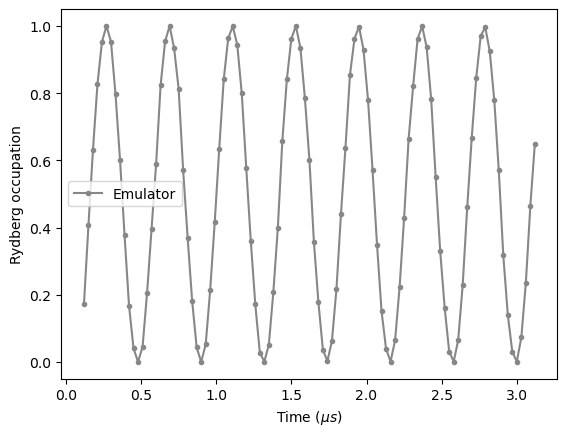

In [14]:
emu_batch = load(emu_filename)

#hardware_report = hardware_batch.report()
emulator_report = emu_batch.report()

times = emulator_report.list_param("run_time")
for i in range (len(times)):
    times[i]=times[i]+ 2*ramp_time
density = [1 - ele.mean() for ele in emulator_report.bitstrings()]
plt.plot(times, density, color="#878787", marker=".", label="Emulator")

plt.xlabel("Time ($\mu s$)")
plt.ylabel("Rydberg occupation")
plt.legend()
plt.show()

Rabi oscillations! The finer we probe the time axis and the more statistics we build with higher shot counts, the closer to a sine this figure will be. But above everything, the program above can be readily deployed in actual quantum hardware so you can consider testing our qubit callibrations by yourself!

## 2. Few-qubit dynamics

Qubits in isolation don't do much. We want to get more of them together, and we want to entangle them. To do so, let's start with a quick recap of the Hamiltonian describing the dynamics of several atoms, which we will index by $i$. 

Dynamics are controlled, generally, but the **Rabi amplitude** terms, which may or may not include a phase $\phi$, and act individually (but uniformly) on each atom according to

$$
 \sum_i \frac{\Omega(t)}{2} \left( e^{i \phi(t) } | g_i \rangle  \langle r_i | + e^{-i \phi(t) } | r_i \rangle  \langle g_i | \right).
$$

The **deturning** term $\Delta$ represents how off-resonant the laser is from the atomic energy transition and incurr an energy cost (positive or negative) for excitations into the Rydberg state:

$$
\sum_i \Delta(t) \hat{n}_i,
$$

where

$\hat{n}_i= 0|g_i \rangle  \langle g_i | + 1| r_i \rangle  \langle r_i |. $  


Finally, when multiple atoms are excited to a Rydberg state, they are subject to Van der Waals interactions, which is captured by the term
$$
\sum_{i < j} V_{ij} \hat{n}_i \hat{n}_j
$$

where $V_{ij}$ is given by
$$
V_{ij} = \frac{C_6}{|x_i - x_j|^6}.
$$

Here $C_6 = 862,690 MHz \mu m^6 $ is the Rydberg interaction coefficient.

Bringing it all together, we obtain

$$
\frac{\mathcal{H}(t)}{\hbar} = \sum_i \frac{\Omega(t)}{2} \left( e^{i \phi(t) } | g_i \rangle  \langle r_i | + e^{-i \phi(t) } | r_i \rangle  \langle g_i | \right) - \sum_i \Delta(t) \hat{n}_i + \sum_{i < j} V_{ij} \hat{n}_i \hat{n}_j,
$$
as in the previous chapter.

### 2a. Rydberg blockade phenomenon

When neutral-atom qubits are brought into contact, they may interact and entangle. The physical processes by which this can be controlled is characterized by the last term in the Hamiltonian above, the 2-qubit interaction energy $V_{ij}$.

The key observation is that when an atom is “puffed-up” to a **Rydberg state**, it is capable of a strongly shifting the energies of the states of adjacent atoms, conditional on them being also excited to Rydberg levels. In other words, if two atoms "$i$" and "$j$" are close together (on a length scale of order 𝜇𝑚), they interact through a state-dependent energy shift. If noneo or only one atom is in the Rydberg state, there is no energy shift as $\hat{n}_i \hat{n}_j=0$. If both atoms are in the Rydberg state, however, the energy of that state is further shifted by $V_{ij}$. If this shift is large enough, the state with double excitation is effectively expelled from the Hilbert space: no combination of $\Omega$ and $\Delta$ will enable us to access it! This phenomenon is known as the **Rydberg blockade**, as an atom excited to a Rydberg state blocks its neighbors from exciting as well.

> it is crucial to appreciate: the Rydberg blockade phenomnenon can **digitize** the conditional dynamics. Once atoms get close enough, they are **always** blocked no matter the details of how close they get. Because the $1/r_{ij}^6$ power law decays extremely fast, once atoms are far away, they are **always** independent. **No fine tuning is necessary**, but, of course, how one leverages these interactions for generating complex quantum dynamics can be quite subtle.  

But how close is "close enough"? How can we observe this Rydberg blockade phenomenon? And how can we use it for solving interesting problems with our quantum computer? 

Answering these questions is the topic of this section!

### 2b. The Rydberg blockade radius

Let's start by quantifying our sense of how much "close" is "too close", i.e., what is the characteristic distance at which the Rydberg blockade mechanism sets in.

For this, consider a problem of two atoms in the presence of a Rabi oscillation field. The Hamiltonian for this problem can be written

$$
H_{12}= \frac{\Omega}{2} \left( |g_1 \rangle \langle r_1| + |g_2 \rangle \langle r_2| + H.c.\right) +V_{12}\hat{n}_1\hat{n}_2
$$



<img style="float: right;" src="./assets/pic2-13.png" width="350" height="auto" />


If the atoms are a distance $d$ apart, $𝑉_{12}=C_6/d^6$.

To set up the scale for blockading interactions, we need to think a bit like physicists. We ought to appreciate that $𝑉_{12}$ is a power-law, and does not have a natural scale for large or small $d$. Yet, the blockading phenomenon is always a function of our capacity to generate excitations into the $|r_1 r_2 \rangle$ state. While the enegy of that state depends on the distance between the atoms, if $\Omega$ is large enough, in fact, it is always possible to generate excitations into it. Converselly, for a fixed Rabi amplitude, there is always a distance small enough beyond which we cannot access the doubly excited state any more.

So all we have to do is to compare $𝑉_{12}$ with $\Omega$ to set that characteristic distance. Equating $𝑉_{12}=\Omega$, we can solve for said corresponding distance, which we name $R_B$, obtaining

$$
R_B= (C_6⁡/\Omega)^{1/6}.
$$

A clear interpretation of this can be obtained by looking at the spectrum of $H_{12}$, first in the absence of $\Omega$, and then in a "hypothetical" absence of $V_{12}$. We reproduce this spectrum as function of $d$ in the figure above. The  $y$-axis corresponds to energy and black dashes at $d=0$ mark the spectrum in the absence of $V_{12}$. The red curves, conversely, correspond to the energy levels in the absence of $\Omega$, when only $V_{12}$ is present. The red curve that bends up is the energy of the $|r_1 r_2 \rangle$ state. The blockade radius marks the crossing between $\Omega$, and $V_{12}$. Atoms at any distance smaller than at this crossing simply cannot be excited by the Rabi amplitude.

> Note that the argument above works when only one dynamic energy scale exists, $\Omega$. When detuning values are present, a similar argument applies but, in this case, first one has to combine $\Omega$ and $\Delta$ into the true dynamical energy scale of the qubits. In this case, the blockade radius formula generalizes to
> $$
> R_𝒃 = [\frac{C_6}{⁡{\sqrt{\Omega^2 + \Delta^2}⁡}}]^{1/6}
> $$

#### Example: Two-atom dynamics

Let's go back to our Rabi oscillations problem and re-study the problem with two atoms in order to observe the effects of the Rydberg blockade.

Let's start by picking up some scales for dynamics
First let's start with a little DIY function that ingests the qubit register and a given

In [15]:
detuning=0
max_omega = 2*np.pi*2

C6 = 2*np.pi * 862690;

Rb = (C6 / max_omega) ** (1/6)
print("Rydberg Radius: ",Rb)

Rydberg Radius:  8.692355131311515


We are picking $\Omega = 2MHz$ and converting to $rad/\mu s$ units. We are expecting $R_B\approx 8.7 \mu m$ here.

Let's start by analyzing geometry here. We put two atoms into our register, considerably far apart with respect to our predicted $R_B$ so they do not interact with each other. Let's say we begin with atoms separated by $20\mu m$ along the y-direction.

In [21]:
#pick a distance!
dist = 8.8

atom_coord=[(0, 0), (0,dist)]

ListOfLocations(atom_coord).show()

Note the "Blockade radius" toggle button. If you type $8.7$ here, our expected characteristic radius of interaction, and click on "Toggle", you will see that, indeed, the atoms seem far apart enough to not interact.

Now let's put together a short DYI function that ingests a geometry, conditions for a constant detuning and a trapezoidal Rabi amplitude waveforms, a total evolution time, and runs a full Rabi oscillation experiment while plotting the Rydberg occupation of a single atom as function of time, same as we did above. Here we go:

In [22]:
def many_body_dynamics(atom_coord, max_omega, max_run_time):

    run_times = np.linspace(0, max_run_time-0.2, 61)
    n_atom = len(atom_coord)
    
    program = (
        start.add_position(atom_coord)
        .rydberg.rabi.amplitude.uniform.piecewise_linear(durations = [0.1, "run_time", 0.1],values = [0, max_omega, max_omega, 0])
        .detuning.uniform.constant(duration=sum(run_times), value=0)
        )
    
    two_atom_job = program.batch_assign(run_time=run_times)
    
    emulator_batch = two_atom_job.bloqade.python().run(100)
    
    emulator_report=emulator_batch.report()
    times = emulator_report.list_param("run_time")
    for i in range (len(times)):
        times[i]=times[i]+ 0.2
    density = [n_atom - n_atom*ele.mean() for ele in emulator_report.bitstrings()]
    plt.plot(times, density, color="#878787", marker=".", label="Emulator")
    
    plt.ylim(0, n_atom) 
    plt.xlabel("Time ($\mu s$)")
    plt.ylabel("Rydberg population")
    plt.legend()
    plt.show()

Now we are ready to run! Let's see what we get for a $2 \mu s$ simulated experiment.

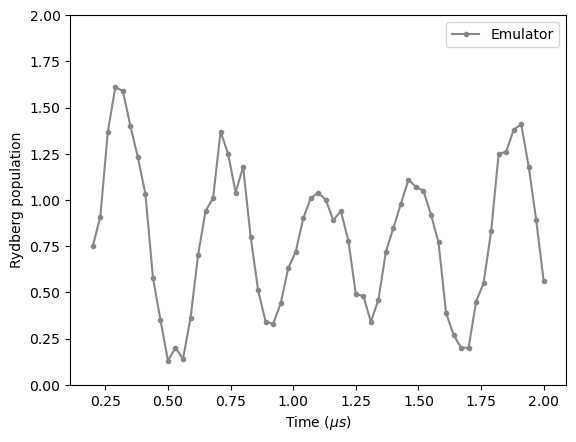

In [23]:
max_run_time = 2.0

many_body_dynamics(atom_coord, max_omega,max_run_time)

* *Exercise 2b*: Describe what you see in comparison with the single-atom exercise above. Then, go back up to `atom_coord` and redefine `dist` to something much closer than the expected $R_B$ for our system, say $6 \mu m$. What do you see? (look at amplitude and frequency!) How do you interpret it in terms of the Rydberg blockade phenomenon? Repeat the exercise for 3 atoms in different geometries (say line and isoceles triangle)

## 3. Many-body Ordered phases

Let's extend the analysis to many qubits. We will start this session by building up our intuition with an exercise straight away:

* *Exercise 3*: In the figure below we have a nine-qubit register in the shape of a regular square lattice. Assume these atoms are exposed to a detuning field that favors excitation of as many atoms as possible to the Rydberg state. Assume as well, however, that their interactions lead to Rydberg blockade constraints such as $R_{B,a}$ and $R_{B,b}$. For each of these cases determine how many atoms can be excited and the corresponding geometric pattern.

<img src="./assets/square_lattice.png" width="350" height="auto" />

Welcome to the realm of simulating ordered phases of matter with neutral-atom quantum computers! By positioning qubits in different lattice structures, we can leverage the natural Rydberg interaction to create organizational patterns found in nature such as anti-ferromagnets and more exotic systems. The preparation of these patterns often involves a quantum dynamic process, allowing us to further simulate how different patterns emerge in a time-dependent fashion. One can also study how perturbations in these patterns evolve and change character. Some of these experiments, at the largest possible scales achieved with Aquila (256 qubits), can become extremely strenuous to classical computers.

To set up the paradigm, this session will explore a bit the space of ordered phases in 2D square lattices and a specific protocol for creating these phases: the adiabatic protocol. This will be your first official engagement with a quantum heuristic algorithm in this course!

### 3a. The square lattice Rydberg phase diagram

This may be your first interaction with what in physics is called a "phase diagram". A quantum one for that matter! This type of diagram describes the different ordering structures that an interacting many-body system may spontaneously display as function of parameters that controls its energy or other physical properties.

Let's look at what a phase diagram for our standard Rydberg atom system looks like when atoms are positioned in a regular square lattice:

<img src="./assets/square_phasediagram.png" width="700" height="auto" />

This figure is adapted from the following reference: R. Samajdar et al., Phys. Rev. Lett. 124, 103601 (2020). On the left, we see the atomic square lattice, while the center figure is our phase diagram; insets on the right point to different Rydberg excitation patterns corresponding to each of the phases in the center diagram.

In the phase diagram, the $x$ and $y$ axes are given by, respectively, the ratio of the detuning field to the Rabi amplitude (in our notation in this course, substitute $\delta \to \Delta$), and the ratio of the blockade radius defined by the Rabi amplitude $ R_B= (C_6⁡/\Omega)^{1/6}$ over the square lattice spacing size $a$. The blue scale corresponds to a quantity known as the "entanglement entropy", capable of capturing changes of quantum behavior of many-body systems. No need to overthink about its definition. Just focus on the fact that the phase diagram displays "domes" (labeled Checkerboard, Star, Rombic, etc ). 

These domes correspond to what we call different "phases", that describe characteristic excitation patterns of the square lattice of qubits whenever parameters of the system lie inside a given dome. These excitation patterns correspond to what is the ground state, the quantum state of lowest energy, for the system. Let's learn how to access these states via a quantum algorithm!

### 3b. Preparing checkerboards with an adiabatic protocol

If we can easily access the ground state in any region of this phase diagram, we can rely on the adiabatic theorem to transform that state into the ground state of any other phase.

> the adiabatic theorem states, in general lines, that under slow enough modifications of the parameters of a quantum system, its the ground state can be smoothly transformed while remaining the lowest energy state. Slow enough is defined her as in comparison with the energy gap (divided by $\hbar$, Planck's reduced constant) between the ground state and the lowest excited state

As it turns out, for large negative values for the detuning $\Delta$, the ground state is indeed just a product $| 000.000 \rangle$. A quantum algorithm transforms a given state, typically this product all-0 state, into a target state that answers a computational question, or into a superposition state whose highest weight goes for the state that solves our question. So here is how we pick waveforms that use the adiabatic theorem to prepare a checkerboard state of the Rydberg-atom square lattice:

1. start with large negative $\Delta$ and, as mandated by the quantum hardware, $\Omega = 0$.
2. ramp up $\Omega$ to a given y-cut on the phase diagram that positions you at the "height" of the checkerboard dome. For example, we can pick $\Omega$ so that we are at the dotter horizontal line at $R_B/a\approx 1.2$.
3. ramp $\Delta$ slowly from negative to positive through a trajectory - which can be taken linear for simplicity - that connects us to a target value in the $x$-axis, such as $\frac{\Delta}{\Omega}\approx 2.7$. This will put us exactly at the crossing of the dashed and dotter lines in the phase diagram above!

That is it! Once this process is done, one ramps the Rabi amplitude waveform down, as is mandatory, and measured. At the end of this protocol, if we chose our numbers correctly, we should have prepared a state with high likelihood of corresponding to a checkerboard state.

Let's do that with Bloqade. First, let's pick relevant parameters


In [24]:
# Change the lattice spacing to vary the atom separation a, and thus also Rb/a
delta_end=42.66 #final detuning
omega_max=15.8 #max Rabi amplitude
sweep_time = 2.4 #time length of program 
lattice_spacing = 7.0 #size of edges of square lattice
L=3 # number of unit cells in each direction

C6 = 2*np.pi * 862690;
Rb = (C6 / (omega_max) )** (1/6) # R_B during bulk of protocol
print("Rb/a: ",Rb/lattice_spacing)


print("Delta/Omega: ", delta_end/omega_max)

Rb/a:  1.1952668759300964
Delta/Omega:  2.6999999999999997


Now we can do our standard process for creating a program. Notice that, in this case, we do not care about every step of the time-dependent evolution, but only the final state. So the process is much simpler and we can forget batching.

> note a subtlety about Bloqade. While `start` is necessary to begin including atoms to the register via `add_position()`, if we use a formal pre-defined geometry object from within Bloqade, such as `Square()` below, we skip the `start` object!

In [25]:
rabi_amplitude_values = [0.0, omega_max, omega_max, 0.0]
rabi_detuning_values = [-delta_end, -delta_end, delta_end, delta_end]
durations = [0.8, sweep_time, 0.8]

prog = (
    Square(L, lattice_spacing=lattice_spacing)
    .rydberg.rabi.amplitude.uniform.piecewise_linear(durations, rabi_amplitude_values)
    .detuning.uniform.piecewise_linear(durations, rabi_detuning_values)
)


Finally, run and report as usual!

In [27]:
emu_prog=prog.bloqade.python().run(shots=200)
emu_prog.report().show()

Looks like our protocol is pretty good! In 100 shots, we recover the expected checkerboard pattern! 

This success will certainly decrease if we scale the system size (not recommended without using an actual quantum computer!). In that case, gap sizes will reduce and the protocol will have to be adjusted for longer times, or even optimized to make sure that the adiabatic passage is done slowly enough.

# Conclusions
This marks the end of the secon chapter. Congratulations as now you are familiarized with the basic phenomenology of neutral-atom quantum computers. 
Revisiting again our learning objectives, now you are able to
- Describe the Rydberg bloqade phenomenon
- Compute the dynamics of multi-qubit Rydberg systems describing the effects of the blockade on Rabi oscillations
- Analyze Rydberg phases on square lattices

This chapter closes the initiate content for QuEra's training on neutral-atom quantum computing. From now, you may branch to specific topics of interest, including solving combinatorial optimization problems, quantum machine learning, simulating more complex quantum dynamics and phases, and much more! 